#Setup

In [71]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, mean_squared_error
from math import sqrt

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.1'

#Data Scrubbing

Load and View Data

In [72]:
data = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/diabetic_data.csv')
data.head() 

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [73]:
data.shape

(101766, 50)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [75]:
# check the number of object types
data.dtypes.value_counts()

object    37
int64     13
dtype: int64

In this dataset, there are a total of 50 columns. The breakdown is as follows:  
2 of these columns are target variable/labels, and both are text features.  
48 of these columns obtains 35 text features and 13 numeric features.

#Features Engineering


Let's see the correlation of each feature using heatmap

In [0]:
#corr = data.corr()
#plt.subplots(figsize=(20,10))
#sns.heatmap(corr, annot=True)

Let's drop some columnus that has value as id and missing value greater than 80%

In [77]:
data = data.drop(['encounter_id','patient_nbr','weight','admission_type_id','discharge_disposition_id',
                  'admission_source_id','payer_code','medical_specialty','diag_1','diag_2','diag_3'], axis=1)

data.shape

(101766, 39)

In [78]:
data.isna().sum()

race                        0
gender                      0
age                         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin                     0
glyburide-metformin         0
glipizide-metformin         0
glimepirid

There is no missing data

Data Visualization

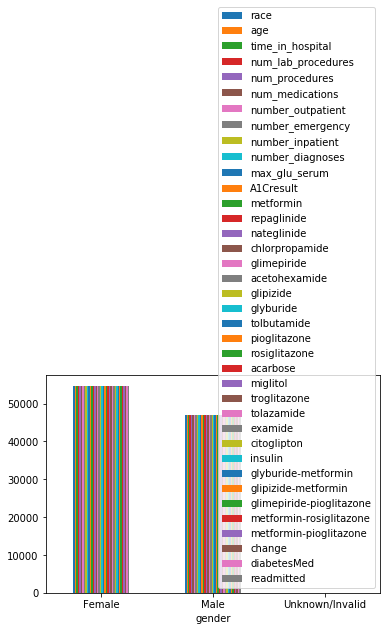

In [79]:
# Group by gender
data.groupby('gender').count().plot.bar(rot=0)

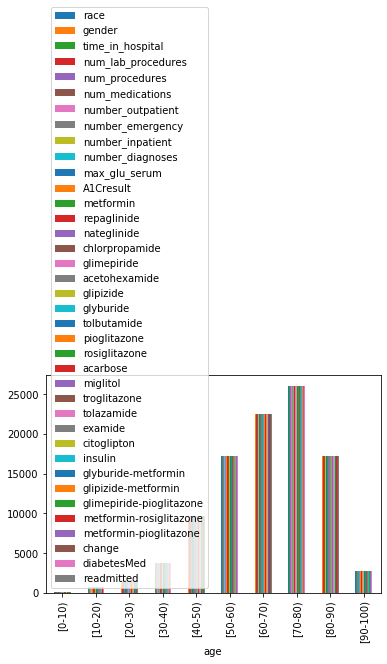

In [80]:
# Group by age
data.groupby('age').count().plot.bar()

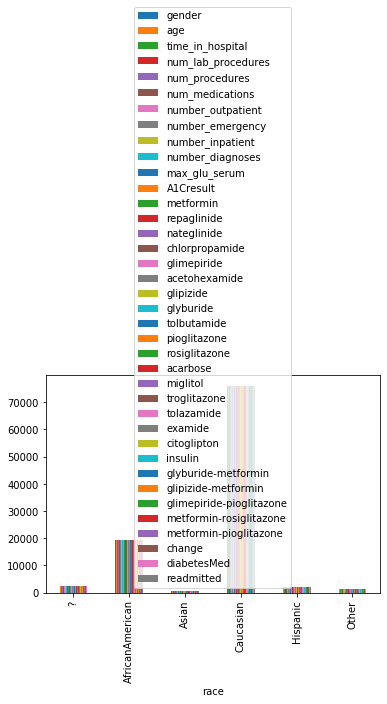

In [81]:
# Group by race
data.groupby('race').count().plot.bar()

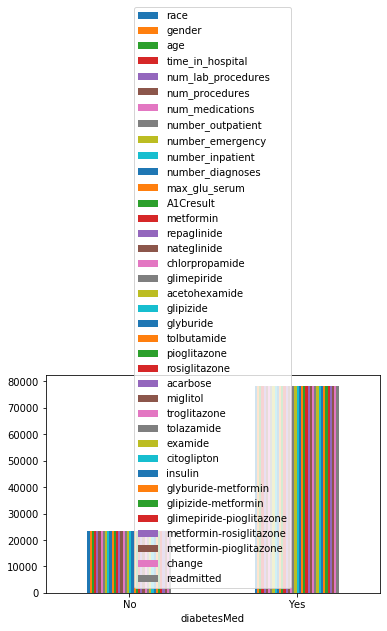

In [82]:
# Group by diabetes medication prescribed
data.groupby('diabetesMed').count().plot.bar(rot=0)

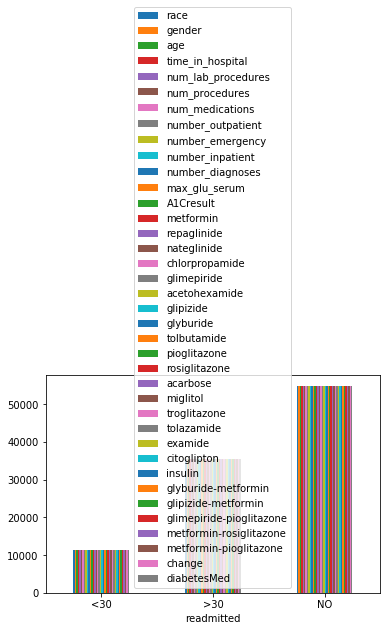

In [83]:
# Group by readmitted
data.groupby('readmitted').count().plot.bar(rot=0)

Normlizing the features that has numerical value

In [0]:
scaler = MinMaxScaler(feature_range=[0, 3])
data.iloc[:,3:11] = scaler.fit_transform(data.iloc[:,3:11])

In [85]:
data.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),0.000000,0.916031,0.0,0.0000,0.000000,0.0,0.000000,0.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),0.461538,1.328244,0.0,0.6375,0.000000,0.0,0.000000,1.6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),0.230769,0.229008,2.5,0.4500,0.142857,0.0,0.142857,1.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),0.230769,0.984733,0.5,0.5625,0.000000,0.0,0.000000,1.2,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),0.000000,1.145038,0.0,0.2625,0.000000,0.0,0.000000,0.8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


Choose X features y labels

In [0]:
X_diabetesMed = data.iloc[:,0:34]
X_readmitted = data.iloc[:,0:35]
y_diabetesMed = data.iloc[:,-2] 
y_readmitted = data.iloc[:,-1] 

In [87]:
X_diabetesMed.shape, y_diabetesMed.shape, X_readmitted.shape, y_readmitted.shape

((101766, 34), (101766,), (101766, 35), (101766,))

Convert categorical value to numerical

In [0]:
X_diabetesMed = pd.get_dummies(X_diabetesMed)
X_readmitted = pd.get_dummies(X_readmitted)

In [89]:
X_diabetesMed.shape, X_readmitted.shape

((101766, 102), (101766, 104))

In [90]:
# convert 'diabetesMed' label to numerical
y_dia = y_diabetesMed.map(lambda x:int(1) if x=='Yes' else int(0))

y_dia.head()

0    0
1    1
2    1
3    1
4    1
Name: diabetesMed, dtype: int64

In [91]:
# convert 'readmitted' label to numerical
y_rea = y_readmitted.map(lambda x:int(0) if x=='No' else int(1) if x=='<30' else int(2))

y_rea.head()

0    2
1    2
2    2
3    2
4    2
Name: readmitted, dtype: int64

Select the best 50 features from both diabetes and readmitted  

In [0]:
skb = SelectKBest(chi2, k=50)
X_dia = skb.fit_transform(X_diabetesMed, y_dia) 
X_rea = skb.fit_transform(X_readmitted, y_rea)

# For vizaulizing the important features
X_dia_fit = skb.fit(X_diabetesMed, y_dia)
X_rea_fit = skb.fit(X_readmitted, y_rea)

In [93]:
X_dia.shape, X_rea.shape

((101766, 50), (101766, 50))

For diabetesMed

In [0]:
X_dia_scores = pd.DataFrame(X_dia_fit.scores_)
X_dia_columns = pd.DataFrame(X_diabetesMed.columns)
dia_scores = pd.concat([X_dia_columns,X_dia_scores],axis=1)
dia_scores.columns = ['Features','Score']

See the 50 highest score of importance features 

In [95]:
print(dia_scores.nlargest(50,'Score'))  #print 50 best features

                  Features       Score
6         number_inpatient  994.937608
0         time_in_hospital  120.382533
90            insulin_Down   92.357920
5         number_emergency   64.870867
91              insulin_No   60.224382
22             age_[50-60)   38.833315
37        metformin_Steady   38.724389
93              insulin_Up   38.245607
7         number_diagnoses   29.059329
3          num_medications   24.786171
18             age_[10-20)   20.107193
8                   race_?   19.133618
2           num_procedures   16.521367
19             age_[20-30)   15.882274
25             age_[80-90)   14.795801
17              age_[0-10)   14.034622
32            A1Cresult_>8   13.767366
28      max_glu_serum_>300   12.728291
34          A1Cresult_Norm   11.333367
4        number_outpatient   11.281901
36            metformin_No   10.490585
24             age_[70-80)    9.884529
38            metformin_Up    9.129025
57          glipizide_Down    9.121782
1       num_lab_procedure

For 'readmitted'

In [0]:
X_rea_scores = pd.DataFrame(X_rea_fit.scores_)
X_rea_columns = pd.DataFrame(X_readmitted.columns)
rea_scores = pd.concat([X_rea_columns,X_rea_scores],axis=1)
rea_scores.columns = ['Features','Score']

See the 50 highest score of importance features 

In [97]:
print(rea_scores.nlargest(50,'Score'))  #print 50 best features

                  Features       Score
6         number_inpatient  994.937608
0         time_in_hospital  120.382533
90            insulin_Down   92.357920
5         number_emergency   64.870867
91              insulin_No   60.224382
22             age_[50-60)   38.833315
37        metformin_Steady   38.724389
93              insulin_Up   38.245607
7         number_diagnoses   29.059329
3          num_medications   24.786171
18             age_[10-20)   20.107193
8                   race_?   19.133618
2           num_procedures   16.521367
19             age_[20-30)   15.882274
25             age_[80-90)   14.795801
17              age_[0-10)   14.034622
32            A1Cresult_>8   13.767366
28      max_glu_serum_>300   12.728291
34          A1Cresult_Norm   11.333367
4        number_outpatient   11.281901
36            metformin_No   10.490585
24             age_[70-80)    9.884529
38            metformin_Up    9.129025
57          glipizide_Down    9.121782
1       num_lab_procedure

Split the data for training and testing set in ration 70%-30%

In [0]:
#For diabetesMed
X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X_dia,y_dia, test_size=0.3, shuffle = True, random_state=42)

In [0]:
#For readmitted
X_train_rea, X_test_rea, y_train_rea, y_test_rea = train_test_split(X_rea,y_rea, test_size=0.3, shuffle = True, random_state=42)

#RandomForest Model 

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=10)

for 'diabetMed'

In [101]:
# Perform Cross Validation
cross_val_score(rnd_clf, X_train_dia, y_train_dia, cv=3, scoring='accuracy').mean() 

0.999073500387938

In [0]:
# Fit the model with training set
t0 = time.time()
rnd_clf.fit(X_train_dia, y_train_dia)
t1 = time.time()

In [103]:
print("Training took {:.2f}s".format(t1-t0))

Training took 0.50s


In [104]:
# Test the model with testing set
rnd_clf.score(X_test_dia, y_test_dia)

0.9991811333114969

for 'readmitted'

In [105]:
# Perform Cross Validation
cross_val_score(rnd_clf, X_train_rea, y_train_rea, cv=3, scoring='accuracy').mean() 

0.8768740715115273

In [0]:
# Fit the model with training set
t0 = time.time()
rnd_clf.fit(X_train_rea, y_train_rea)
t1 = time.time()

In [107]:
print("Training took {:.2f}s".format(t1-t0))

Training took 1.14s


In [108]:
# Test the model with testing set
rnd_clf.score(X_test_rea, y_test_rea)

0.8755650180150671

In [0]:
# Predict y 'readmitted'
y_pred_rnd_rea = rnd_clf.predict(X_test_rea)

In [110]:
# See Precision, Recall and F1 report
print(classification_report(y_test_rea, y_pred_rnd_rea))

              precision    recall  f1-score   support

           1       0.22      0.04      0.07      3425
           2       0.89      0.98      0.93     27105

    accuracy                           0.88     30530
   macro avg       0.56      0.51      0.50     30530
weighted avg       0.82      0.88      0.84     30530



#SVM (nom-linear kernel) Model 

In [0]:
svm_clf = svm_clf = SVC(gamma='auto', degree=2, kernel='poly') #Non-linear degree=2

for 'diabetMed'

In [112]:
# Perform Cross Validation
cross_val_score(svm_clf, X_train_dia, y_train_dia, cv=3, scoring='accuracy').mean()

0.9947498516904334

In [0]:
# Fit the model with training set
t0 = time.time()
svm_clf.fit(X_train_dia, y_train_dia)
t1 = time.time()

In [114]:
print("Training took {:.2f}s".format(t1-t0))

Training took 28.82s


In [115]:
# Test the model with testing set
svm_clf.score(X_test_dia, y_test_dia)

0.9967572879135277

for 'readmitted'

In [116]:
# Perform Cross Validation
cross_val_score(svm_clf, X_train_rea, y_train_rea, cv=3, scoring='accuracy').mean()

0.8886518052231157

In [0]:
# Fit the model with training set
t0 = time.time()
svm_clf.fit(X_train_rea, y_train_rea)
t1 = time.time()

In [118]:
print("Training took {:.2f}s".format(t1-t0))

Training took 137.48s


In [119]:
# Test the model with testing set
svm_clf.score(X_test_rea, y_test_rea)

0.8878152636750737

In [0]:
# Predict y 'readmitted'
y_pred_svm_rea = svm_clf.predict(X_test_rea)

In [121]:
# See Precision, Recall and F1 report
print(classification_report(y_test_rea, y_pred_svm_rea))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3425
           2       0.89      1.00      0.94     27105

    accuracy                           0.89     30530
   macro avg       0.44      0.50      0.47     30530
weighted avg       0.79      0.89      0.84     30530



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plot the learning curve for 'readmitted'

In [0]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

  axes[0].set_title(title)
  if ylim is not None:
        axes[0].set_ylim(*ylim)
  axes[0].set_xlabel("Training examples")
  axes[0].set_ylabel("Score")

  train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
  axes[0].grid()
  axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
  axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
  axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
  axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
  axes[0].legend(loc="best")
  return plt

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

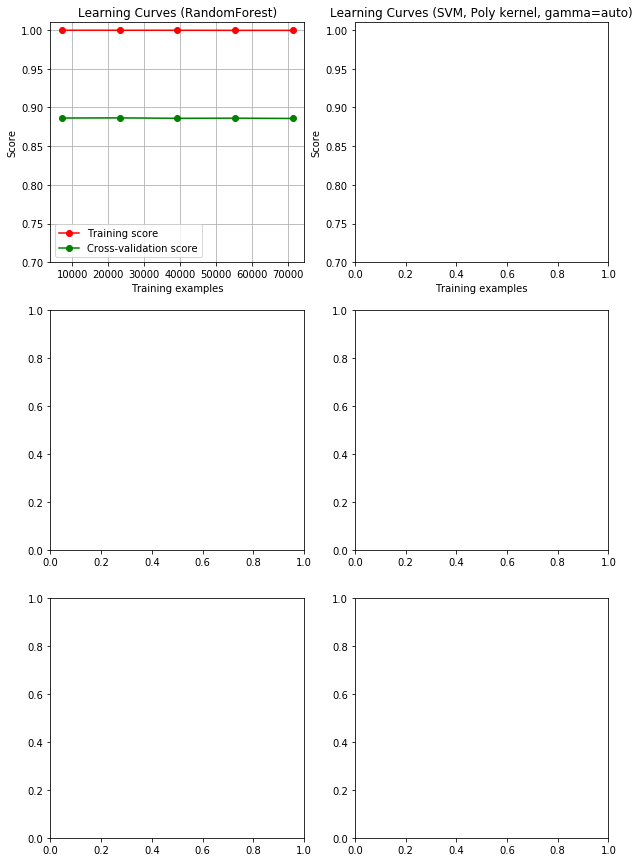

In [123]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = X_rea, y_rea

title = "Learning Curves (RandomForest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)

estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves (SVM, Poly kernel, gamma=auto)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
estimator = SVC(gamma='auto')
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

Overall, all accuracies scores are not bad, and we can increase those accuracies by playing around with the n_estimators for RandomForest and degree for SVM non-linear classifier, but the trade off for this approach is time consuming. Therefore, tuning the model using GridSearch CV is recommended.  

#Tuning the RandomForest using GridSearchCV

In [0]:
pipe = make_pipeline((RandomForestClassifier()))
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"randomforestclassifier": [RandomForestClassifier()],
                 "randomforestclassifier__n_estimators": [50,100,200,500],
                 "randomforestclassifier__max_depth":[10,30,50,100,None],
                 "randomforestclassifier__min_samples_leaf":[5,10,20,40,100],
                 "randomforestclassifier__max_leaf_nodes": [5,10,20,50]}
              ]

In [0]:
# create a gridsearch of the pipeline, then fit the dataset to find best model
gs = GridSearchCV(pipe, grid_param, verbose=0,n_jobs=-1)

for 'readmitted'

In [0]:
# Fit the model with training set
best_model_rea = gs.fit(X_train_rea, y_train_rea)

In [134]:
# See the best learning model parameters
print(best_model_rea.best_estimator_)

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=5, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=50, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)


In [136]:
# Test the model with testing set
print(("The accuracy is:"), best_model_rea.score(X_test_rea, y_test_rea))

The accuracy is: 0.8878152636750737


#Summary and Conclusion

In this diabete patients dataset, many methods were used at the data cleansing section, especially at the feature engineering phase.  

After many experiments on training models above, the RandomForest model is considered the best model that produced the accuracies around 99% and 88% for 'diabetestMed' 'readmitted, respectively. SVM (non-linear) model also produced similar accuracies but took way longer different for the learning time. Of course, RandomForest is the winner for classifying diabetes patient ('diabetesMed'). Below is the details bar graphs of the experiment.

![alt text](https://drive.google.com/uc?id=1uPtmTGWp8Ci0BavBzjLE_Sr1jysSGq-G)

![alt text](https://drive.google.com/uc?id=1vk4DYi2m3VR19sfnKpTHJ2t_msWKJtMs)

So, which classifier is the best for patient who readmitted? Let's take a look at the average F1 score, RandomForest F1=0.5 > SVM F1=0.47, this mean RandomForest model predict better in term of both precision and recall. Now, how can we improve the models accuracies? Let's take a look at learning curve. It can be seen that, increasing sample set size will not help to improve the learning performance.

Let's try with GridSearchCV, one of the best techniques to find the best model, also known as model tuning technique. In this assignemt, GridSearchCV was used to tune the classifier for readmitted patient, but by looking at GridSearch CV learning model with many different parameters setup, still the performance was not improved at all. The best parameters setup was shown at the line 134.

Therefore, this can be seen that increasing number of features, n_estimators for RandomForest, degrees for SVM, will not improve both models accuracies; however, RandomForest is considered for best learning model for this dataset.

*Note: An important lesson learned from this data set was when applying PCA and scaling the data was not helpful and even made the model performance worse. This is because most of the data value are categorical (0,1,2 after convertion), therefore, the classifiers would learn better with this descrete value.*

Dataset Link: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008